In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from dateutil.parser import parse
from datetime import datetime
from pmdarima.arima import auto_arima
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
# read csv file into pandas dataframe
oil_data = pd.read_csv('WTI crude oil futures.csv',thousands=',')
# transform the str type of data into datetime type
oil_data['Date'] = pd.to_datetime(oil_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
oil_data = oil_data.set_index('Date').sort_index()
# transform data type
oil_data = oil_data.astype(float)
oil_data

,Open,High,Low,Close,Adj.close,Volume
Date,,,,,,
2015-01-02,53.76,55.11,52.03,52.69,52.69,268708.0
2015-01-05,52.61,52.73,49.68,50.04,50.04,375782.0
2015-01-06,50.00,50.37,47.55,47.93,47.93,451642.0
2015-01-07,48.00,49.31,46.83,48.65,48.65,460083.0
2015-01-08,48.78,49.65,47.73,48.79,48.79,362081.0
...,...,...,...,...,...,...
2022-04-25,101.38,101.55,95.28,98.54,98.54,328153.0
2022-04-26,98.64,102.78,97.06,101.70,101.70,351850.0
2022-04-27,101.76,102.99,99.80,102.02,102.02,278781.0


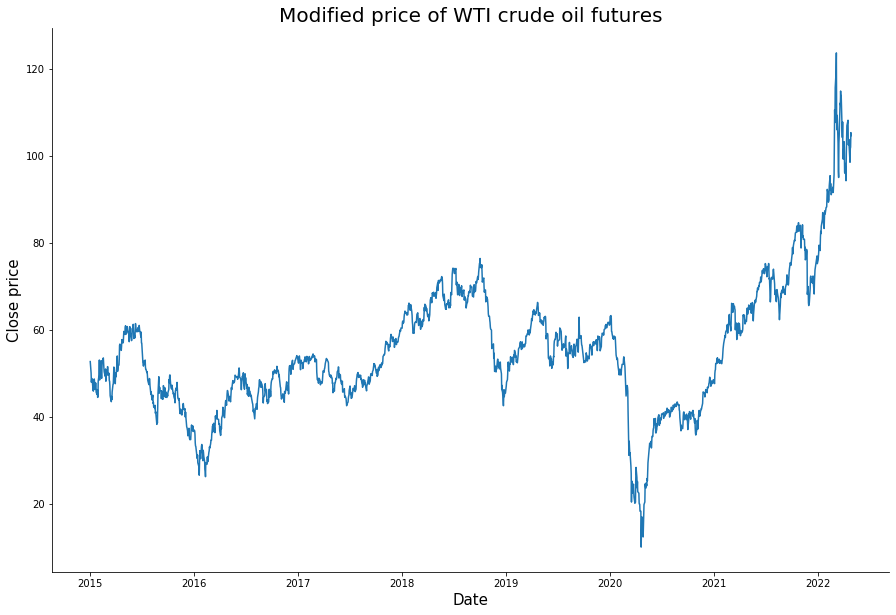

In [3]:
# plot figure of the time series
plt.figure(figsize=(15,10))
plt.plot(oil_data.Close)
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title('Modified price of WTI crude oil futures', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close price', fontsize=15)
plt.savefig('Modified price of WTI crude oil futures',bbox_inches='tight')

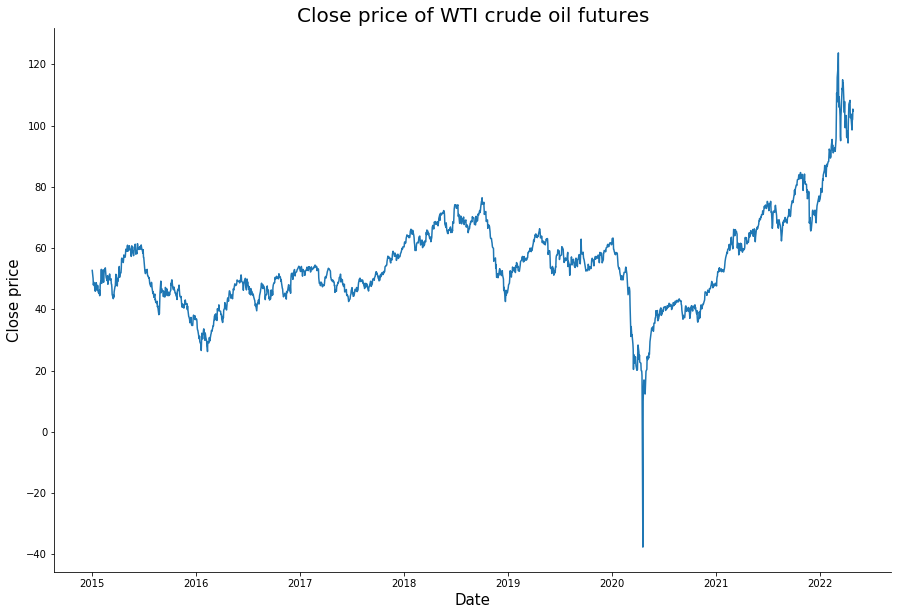

In [3]:
# plot the time series with negative price
plot_data = pd.read_csv('WTI crude oil futures_og.csv',thousands=',')
plot_data['Date'] = pd.to_datetime(plot_data['Date'].apply(lambda x:parse(x).strftime('%Y-%m-%d')))
plot_data = plot_data.set_index('Date').sort_index()
plot_data = plot_data.astype(float)
plt.figure(figsize=(15,10))
plt.plot(plot_data.Close)
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title('Close price of WTI crude oil futures', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close price', fontsize=15)
plt.savefig('Close price of WTI crude oil futures',bbox_inches='tight')

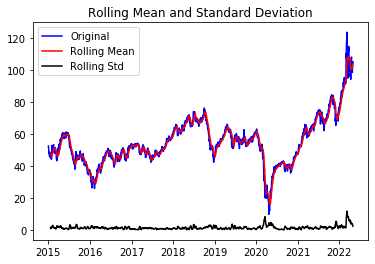

Results of dickey fuller test
Test Statistics                  -0.939851
p-value                           0.774566
No. of lags used                 18.000000
Number of observations used    1825.000000
critical value (1%)              -3.433938
critical value (5%)              -2.863125
critical value (10%)             -2.567614
dtype: float64


In [4]:
# create a function testing the stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
df_close = oil_data['Close']
test_stationarity(df_close)
#The results shows that p-value of ADF test is not significant and thus the series is not a stable series, next we should stabilize it.

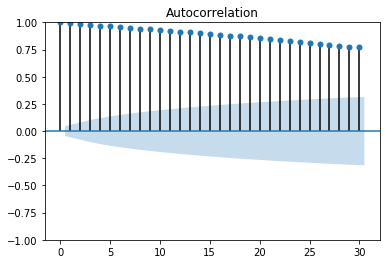

In [5]:
# show the ACF figure before differencing
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_close,use_vlines=True,lags=30)
plt.show() 

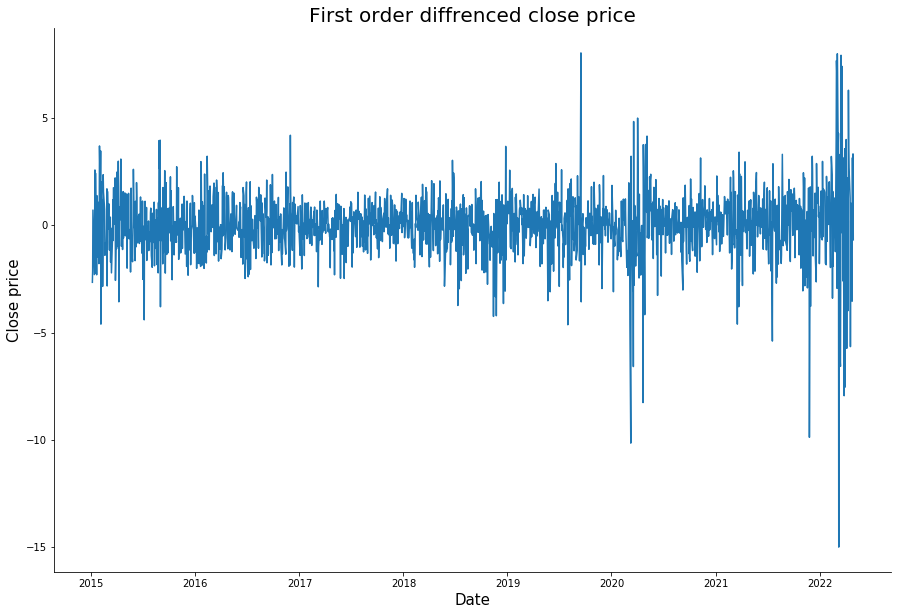

In [6]:
# difference the time series and plot the data
D_df_close = df_close.diff().dropna()
plt.figure(figsize=(15,10))
plt.plot(D_df_close)
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title('First order diffrenced close price', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close price', fontsize=15)
plt.savefig('First order diffrenced close price',bbox_inches='tight')

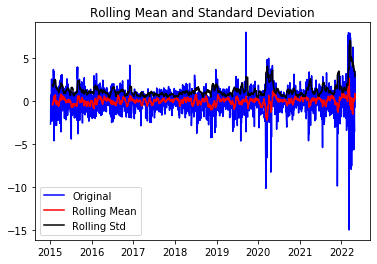

Results of dickey fuller test
Test Statistics               -9.298047e+00
p-value                        1.132046e-15
No. of lags used               1.700000e+01
Number of observations used    1.825000e+03
critical value (1%)           -3.433938e+00
critical value (5%)           -2.863125e+00
critical value (10%)          -2.567614e+00
dtype: float64


In [6]:
# test the stationarity again and check if the test statistics are significant
test_stationarity(D_df_close)

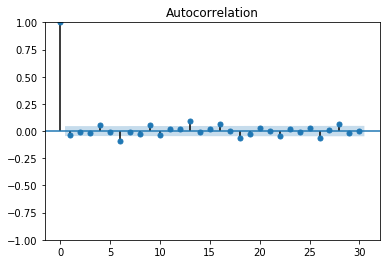

C:\Users\OliverG\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


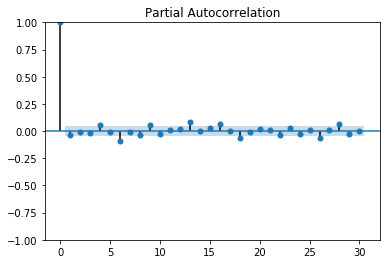

In [7]:
# plot the new ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(D_df_close,use_vlines=True,lags=30)
plt.show()
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(D_df_close,use_vlines=True,lags=30)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6707.779, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6707.741, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6707.698, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6706.438, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6709.482, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.412 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1844
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3352.219
Date:                Tue, 09 Aug 2022   AIC                           6706.438
Time:                        18:08:09   BIC                           6711.957
Sample:                             0   HQIC                          6708.473
                               - 1844                                       

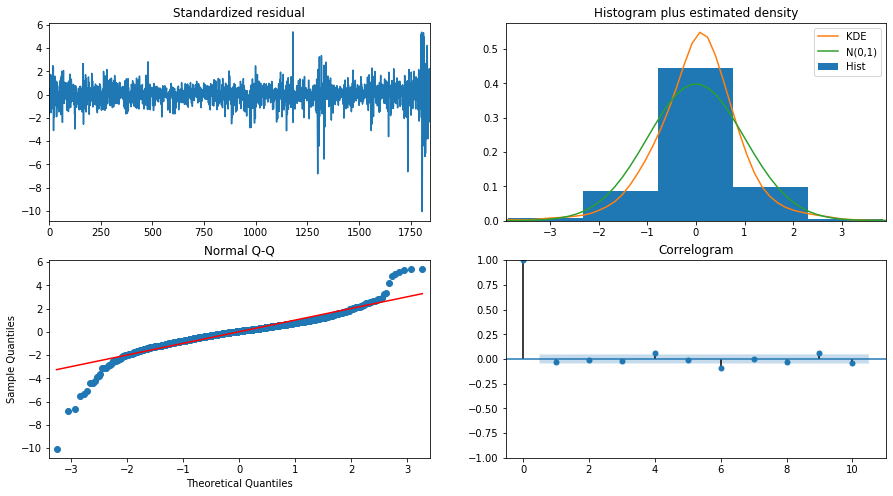

In [8]:
model_autoARIMA = auto_arima(df_close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [41]:
# create the testing list to conduct the parameter search
# the parameters of specific ARIMA model is selected by AutoArima by AIC
stepwise_list = [25,65,125,250]
n_pred_period_list = [1,5,10,20]

training_size = int(len(df_close) * 0.7)
test_size = len(df_close) - training_size

result_dict = {}
for stepwise in stepwise_list:
    for n_pred_period in n_pred_period_list:
        predicted_list = []
        for i in range(training_size,len(df_close)):
            if (i-training_size) % n_pred_period == 0:
                train_data = df_close[i-stepwise:i]
                train_fit = auto_arima(train_data, trace=True, disp=0, suppress_warning=True)
                pred = train_fit.predict(n_pred_period)
                predicted_list.append(pred)
        dict_key = str(stepwise)+' '+str(n_pred_period)
        result_dict[dict_key] = predicted_list
        print(dict_key)
np.save('ARIMA_result_dict.npy', result_dict)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=65.847, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.172, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.716, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.792, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.096, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=62.414, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.452, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=64.413, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=58.889, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=60.702, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.708, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=59.248, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=62.701, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.348 seconds
Performing stepwise search to minimize aic
 ARIM

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=81.525, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.276 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=84.322, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=116.966, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=83.679, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=97.440, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=268.922, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=81.028, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=82.989, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=81.772, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=81.696, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=84.513, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.732, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.557, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=125.421, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=126.284, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.565 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.447, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.253, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=125.066, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=126.177, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.588 seconds
Performing stepwise search to minimize 

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=125.305, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=125.315, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=124.807, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.842 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=125.669, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.502, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.095, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128.812, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=232.127, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.080, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=124.087, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=124.245, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] interc

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=132.335, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.526 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=133.857, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=151.115, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=128.744, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=137.086, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=223.567, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=130.292, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=130.255, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=132.254, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.447 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=132.408, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99.640, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101.542, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.453, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=102.008, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.465 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.388, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=100.279, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=100.254, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.198, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.386 seconds
Performing stepwise search to minimize ai

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.502, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.224, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.212, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.716, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=86.212, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.373 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81.302, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.372, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.263, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.152, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.320 seconds
Performing stepwise search to minimize aic
 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.113, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.404, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.221, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.180, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.492 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.430, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.071, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.523, Time=0.01 sec
 ARIMA(

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.430, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.066, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.475 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.446, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.359, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.636, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.343, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=258.473, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=52.614, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=52.615, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=54.616, Tim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=50.007, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.106, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.132, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=47.604, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.353, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.519 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41.499, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44.649, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.747, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45.386, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.343, Time=0.01 se

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.991, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=66.847, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=66.865, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.189, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=68.835, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.350 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.704, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.716, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.352, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=70.685, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.398 seconds
Performing stepwise search to minimize ai

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=85.065, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=85.354, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.790 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=89.461, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=100.136, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=85.034, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88.628, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.919, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=86.373, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=86.556, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=87.326, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fi

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=99.538, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=79.143, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=85.671, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.622, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=80.875, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=80.904, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=82.902, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.836 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.352, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.103, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=72.516, Time=0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=86.449, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.113 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.528, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.243, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=83.505, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.466 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.687, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.578, Time=0.02 sec
 ARI

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.202, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.189, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53.189, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.924, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=54.719, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.830 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.035, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.650, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=48.646, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.060, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=50.635, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.666 seconds
Performing stepwise search to minimize ai

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.296, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.513, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61.148, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.809, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63.117, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.541, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.399, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61.038, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.900, Time=0.01 sec
 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=68.586, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.297, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.934, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63.004, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.003, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=64.694, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.218 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.349, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62.990, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=63.496, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=64.402, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.445 seconds
Performing stepwise search to minimize

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71.673, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71.629, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.513, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.327 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71.139, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.675, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72.678, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.255, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.600, Time=0.01 sec
 ARI

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97.794, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=99.830, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=107.410, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=116.380, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=102.193, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=105.448, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=279.804, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=103.672, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=103.593, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=105.317, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.549 seconds
Performing stepwise search to min

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=102.149, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=103.838, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.303 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=96.245, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=97.196, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=94.419, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=96.331, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=278.312, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=94.099, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=96.093, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=96.112, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=94.997, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=98.082, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, T

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.125, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.015, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.960, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.634, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=70.794, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.280, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.195, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.150, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=67.330, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=70.988, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.411 seconds
Performing stepwise search to minimize ai

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=86.289, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=88.529, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82.218, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=80.704, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.715, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=82.252, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=82.349, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=84.248, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.610 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=87.956, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=93.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=83.791, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=83.359, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.898,

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71.420, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=70.510, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=71.221, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=72.297, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=74.137, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=72.110, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=70.147, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=72.116, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=73.411, Time=0.14 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.148 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.145, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.220, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73.452, Time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.392, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.386, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.369, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.985, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.781, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.772, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.703, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.653, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.479 seconds
Performing stepwise search to minimize aic
 ARI

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=101.382, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=111.044, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.729, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=98.004, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=287.241, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=97.425, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97.403, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=99.428, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.778 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=101.201, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=110.989, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.586, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=97.838, Time=0.03 sec
 AR

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=104.217, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=106.217, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=107.991, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=120.547, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=102.941, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=107.251, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=286.152, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=104.007, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=104.228, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=106.148, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.662 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.061, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.518, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=91.374, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=88.357, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=93.299, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=99.374, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=121.053, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.015, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=103.932, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=284.127, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=95.303, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.559, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=97.675

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=86.586, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.311, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=85.966, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=85.881, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.619, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=87.540, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.525 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=83.376, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.065, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=85.962, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.611, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=87.588, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.504 seconds
Performing stepwise search to minim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.289, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.246, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.217, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.860, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.437 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.908, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.908, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.239, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76.397, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.355 seconds
Performing stepwise search to minimize aic
 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.231, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.085, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=67.792, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.029, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=69.352, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=69.198, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=71.197, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=73.025, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69.188, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.397, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.645, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=70.602, Time

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=88.593, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=90.932, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.673 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=89.807, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=93.165, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=86.978, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88.845, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=293.469, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=88.583, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=88.752, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=90.915, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.658 seconds
Performing stepwise search to minimize a

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=123.195, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.098, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.691, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.817, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.342, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=122.234, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.212 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=123.217, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.127, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.537, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=119.675, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.771, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=121.254, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise sea

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.951, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=125.021, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=124.439, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.943 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=123.600, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.217, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.902, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.044, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.224, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=121.480, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.206 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.897, Tim

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.089, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.037, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=91.965, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.963, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=92.154, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.336 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.094, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=87.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=86.452, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.251, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.416 seconds
P

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=80.700, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=85.787, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=80.182, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81.450, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=82.668, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=86.398, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.693 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.500, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=88.952, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.568, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.771, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=85.213, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.547, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.851, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98.899, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=98.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.419 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=110.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112.089, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=111.712, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.118, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=111.201, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.300 seconds
Performing stepwise search to minimize 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=163.697, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=187.254, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=160.294, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=171.897, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=304.359, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=161.141, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=161.330, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=162.093, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.617 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=163.494, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=187.755, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=160.240, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=171.934, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : A

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=159.306, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=159.429, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=161.334, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.902 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=164.707, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=173.084, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=159.594, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=162.846, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=306.732, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=160.676, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=160.774, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=162.621, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] interc

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=144.562, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=144.562, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=146.562, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.779 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=161.551, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=141.494, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=147.082, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=305.286, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=143.487, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=143.484, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=144.812, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=126.368, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.484, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.771, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128.375, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=230.970, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.771, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=124.771, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=125.216, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.724 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117.364, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.269, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=119.235, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.381, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51.430, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.066, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.071, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=55.927, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.968, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.665, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=258.718, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51.915, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51.949, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=53.912, Tim

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=82.219, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=82.220, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=84.154, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.713 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=101.797, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82.873, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.796, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=84.711, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=84.681, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.827, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.735, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64.736, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66.270, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.439 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.600, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.493, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.478, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.339, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.496 seconds
Performing stepwise search to minimize aic
 ARI

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=85.544, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=91.584, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82.160, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=81.173, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.408, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=81.576, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=81.411, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=83.324, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.756 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=81.702, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.929, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.803, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=79.579, Time=0.02 sec
 ARIMA(

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=104.636, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=104.694, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=106.692, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.685 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.066, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.422, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93.288, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.123, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=95.251, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.262, Time=0.01 se

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117.097, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=117.718, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=117.901, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.773, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=119.171, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.463, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.767, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.952, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=117.909, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=122.340, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=126.368, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.484, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.771, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128.375, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=230.970, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.771, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=124.771, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=125.216, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.713 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=122.152, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=124.152, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124.152, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=70.119, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=70.118, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=72.128, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.848 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=99.570, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=80.276, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=256.618, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=82.219, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=82.220, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=84.154, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit ti

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=85.544, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=91.584, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82.160, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=81.173, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.408, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=81.576, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=81.411, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=83.324, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.768 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=80.784, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.463, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78.443, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=75.686, 

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=90.915, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.571 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=117.097, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=117.718, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=117.901, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.773, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=119.171, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=116.213, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=117.722, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=117.851, Time=0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.445, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.948, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=125.888, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=125.476, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.419 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=126.368, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.484, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.771, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128.375, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=230.970, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.771, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=124.771, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82.204, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=83.639, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=83.566, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.316, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.428 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=85.544, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=91.584, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82.160, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=81.173, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.408, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=81.576, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=81.411, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=83.324, Tim

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=184.196, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=184.174, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=181.813, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=186.159, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.298, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=184.238, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=184.218, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=181.515, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=186.209, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.392 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=183.188, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.715

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=207.943, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=205.133, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=198.855, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=196.951, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=198.838, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=198.902, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=197.254, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=206.277, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.680 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=232.730, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=248.343, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=228.261, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=275.804, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=277.413, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.458, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=279.528, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=279.152, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.367 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=275.601, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=277.189, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.238, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=279.905, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=278.909, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.368 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=300.438, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=301.124, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=301.250, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=303.400, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=302.822, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.406 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=309.272, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=302.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=303.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=303.502, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=304.141, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=305.305, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.284 seconds
Performing stepwise search 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=321.237, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.559, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315.520, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=315.520, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.574, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=317.454, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=318.808, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=352.534, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=334.950, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=313.082, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=314.836, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=314.813, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=316.824, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept  

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=327.951, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=454.882, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=322.296, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=400.853, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=616.267, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=324.296, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=324.296, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=326.228, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.584 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=328.627, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=450.653, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=322.769, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=396.796, Time=0.04 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=283.250, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=278.386, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=280.383, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=280.382, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=277.125, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=282.296, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=277.369, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=279.368, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.367, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=276.303, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=281.213, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.480 seconds
Performing stepwise search 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=263.451, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=262.508, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=256.927, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=263.775, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=256.937, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=259.247, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=264.035, Time=0.13 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=264.317, Time=0.52 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 3.315 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=260.791, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=261.861, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=261.0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=188.695, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.789, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=189.957, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=191.328, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=191.567, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.388 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=234.183, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=209.560, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=189.971, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=190.549, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=190.671, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=172.901, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=172.448, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=171.592, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=172.427, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=171.760, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=172.366, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.671 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=169.322, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=169.310, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=168.941, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=169.540, 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.596 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=174.099, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175.711, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=175.701, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=172.198, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.616 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=160.014, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=161.437, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=161.498, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=158.037, Time=0.01 

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=160.571, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=160.591, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=162.657, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.901 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=163.859, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=244.335, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=158.588, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=197.420, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=668.971, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=160.436, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=160.462, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=162.532, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] interc

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=180.341, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=174.833, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=176.761, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176.739, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=172.833, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=178.154, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.429 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=173.723, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175.652, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=175.635, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=171.727, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=177.723, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=199.758, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.239 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=201.802, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=196.948, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=198.914, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=198.905, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194.968, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=198.947, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=202.029, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=196.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=198.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=198.838, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=206.797, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=206.773, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=206.442, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.824 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=290.134, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=205.007, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=238.749, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=667.027, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=206.522, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=206.487, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=206.434, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=190.613, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.225, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=189.015, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.888, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186.239, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=189.900, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=190.269, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.958, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.836, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186.112, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=189.876, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.294 seconds
Performing stepwise sea

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=182.042, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.464, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=180.176, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=180.124, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=179.080, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=181.941, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.501, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=180.225, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=180.168, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=179.090, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=143.630, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=145.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=145.593, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=150.665, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=147.357, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.599 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144.163, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.068, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146.062, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=151.278, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=147.873, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.685 seconds
Performing stepwise search to m

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=180.077, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.648 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.325, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.993, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=179.882, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=181.977, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=181.725, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.652 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=178.223, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=179.886, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=179.771, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=181.772, Ti

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=224.312, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=224.520, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=224.710, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=226.306, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=226.308, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=228.301, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=224.321, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.408 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=226.435, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.984, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=225.526, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.855, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=233.881, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=233.572, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=231.518, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=231.714, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=232.444, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=233.517, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=233.517, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=235.517, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=230.771, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=232.766, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=232.767, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=231.046, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=234.762, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=237.104, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=235.137, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.077, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=234.190, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.041, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=236.076, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=237.174, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=235.332, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.142, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=234.282, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.408, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=236.142, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=236.142, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept  

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=238.600, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=240.537, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.808 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=241.684, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=297.316, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237.706, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=265.402, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=724.203, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=237.842, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=237.944, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=239.837, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.754 seconds
Performing stepwise search to m

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=236.062, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=235.071, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=231.448, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.811, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=233.313, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=232.800, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=232.796, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=234.763, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=229.225, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=231.207, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=231.199, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=229.792, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=233.184, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.593 seconds
Performing stepwise search to minim

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=230.398, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=225.627, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=227.575, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=227.541, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=225.988, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=229.563, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.735 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=225.398, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=231.956, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=226.131, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.051, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=230.270, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.030, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=227.032, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=190.642, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=190.718, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=192.686, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=192.636, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=191.374, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=188.889, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=188.114, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=188.623, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=189.699, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=192.525, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.974 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=184.283, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=185.841, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : A

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=218.780, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=214.160, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216.103, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=216.084, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.323, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=217.620, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.388 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=218.313, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=220.297, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=220.276, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=216.889, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=220.236, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=231.476, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=227.928, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229.757, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=229.638, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=226.001, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=229.932, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.236 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=228.663, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=225.359, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=226.911, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=226.636, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=223.538, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=226.887, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
Performing stepwise sea

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=227.825, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229.328, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=229.115, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=225.825, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=230.174, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.461 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=228.820, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.313, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.077, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=226.831, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=231.178, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=234.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=235.423, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=235.161, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=232.186, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=235.883, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.492 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=239.995, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=328.851, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=236.899, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=274.308, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=739.809, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236.852, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=238.539, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : A

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=232.877, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=229.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.591, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.197, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=228.037, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=231.275, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=232.215, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=229.638, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.621, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=229.760, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=228.493, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=230.961, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=209.123, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.464 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=209.950, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=210.408, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=209.925, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=208.951, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=211.739, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.062 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=212.782, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=214.428, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=214.172, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.484, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=217.884, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=214.018, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=215.582, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=215.495, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=213.019, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=216.821, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.598 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=217.090, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=213.411, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=215.106, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=215.040, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.541, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=216.371, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.495 seconds
Performing stepwise sea

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=274.684, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=407.570, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.501, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=351.934, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=751.537, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=274.394, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=274.420, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=275.891, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.934 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=274.870, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=406.712, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.288, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=350.315, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=274.336, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=270.505, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=272.129, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=272.184, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=268.507, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.532 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=272.911, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.891, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=271.334, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=271.425, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=267.901, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.507 seconds
Performing stepwise search to m

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=284.335, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.804 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=287.348, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=416.522, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=282.000, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=358.019, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=752.295, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=283.962, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=283.968, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=285.862, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.690 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=288.488, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.772, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=278.758, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=278.758, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=275.241, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=280.693, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.506 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=277.221, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=279.134, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=279.133, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=275.839, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=281.093, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.567 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325.239, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=327.218, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=327.212, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=325.895, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.545 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=326.763, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325.982, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=327.603, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=327.555, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=325.963, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=329.538, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds
Performing stepwise search to m

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=345.482, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=348.835, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.747 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=345.316, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=346.945, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=346.902, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=345.461, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=348.882, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.840 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=354.928, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=351.015, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=352.766, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=352.758

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=365.946, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=367.849, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=367.830, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=364.273, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=365.841, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=367.752, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=367.735, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=364.121, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.475 seconds
Performing stepwise search to minimize 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=285.791, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=287.699, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=287.705, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=288.080, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=289.567, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.412 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=286.503, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=288.382, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=288.390, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=289.365, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=290.228, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.447 seconds
Performing stepwise search to m

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=211.604, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=252.662, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=233.809, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=210.582, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=211.308, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=211.165, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=212.664, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.469 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=202.640, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=243.829, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=222.406, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=202.494, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=202.363, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : A

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.639 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=188.481, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.780, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.157, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.094, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=182.022, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.462 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.257, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.252, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=184.444, Time=0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.088, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=156.706, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=156.677, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=163.763, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=158.744, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.674 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=164.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=166.377, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=166.349, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=167.727, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.630 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.600 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=236.062, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=235.071, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=231.448, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.811, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=233.313, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=232.800, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=232.796, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=234.763, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=229.225, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=231.207, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=231.199, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=229.792, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=229.130, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.464, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.222, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.197, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=231.489, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.409 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=229.112, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.588, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.311, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.118, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=231.292, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.409 seconds
Performing stepwise search to m

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=263.452, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=306.708, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=278.221, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=261.062, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=260.060, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=261.932, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=261.482, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=260.025, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=261.063, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=261.691, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.702 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=274.845, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=410.243, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=331.609, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=328.060, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.359, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=327.471, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=326.946, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=332.275, Time=0.77 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=327.262, Time=0.19 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.704 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=336.875, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=341.645, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=343.031, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=342.721, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=321.237, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.559, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315.520, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=315.520, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.574, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=317.454, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.361 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=328.042, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=467.468, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=322.364, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=408.799, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=619.247, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=324.360, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=324.361, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=191.656, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186.756, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.541, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.442, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.589, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=189.737, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.203 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=185.699, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=183.429, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=185.149, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=184.971, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=182.698, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=184.517, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds
Performing stepwise sea

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=190.799, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=185.614, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=185.519, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=185.856, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=188.630, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.954 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=220.075, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=218.563, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=220.526, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=220.490, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=217.449, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=273.406, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.803, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=271.510, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=271.557, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=267.815, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=273.188, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.436 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=275.882, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=272.154, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=273.876, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=273.914, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=270.173, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.714 seconds
Performing stepwise search 

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=231.996, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=209.661, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=188.712, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=189.425, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=189.458, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.012 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=174.032, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175.449, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=175.385, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=172.046, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=214.043, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=210.568, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=212.420, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=212.393, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=211.085, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=214.337, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.482 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=214.966, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=215.212, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=217.204, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=217.200, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=215.158, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=217.607, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=216.113, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept  

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=417.032, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.631 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=420.189, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=664.878, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=415.237, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=554.669, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1364.039, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=417.229, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=417.228, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=419.195, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.691 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=423.790, T

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.962, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=443.421, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=441.180, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=458.680, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=514.145, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=490.315, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=453.489, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=455.359, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=455.339, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=456.694, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=454.320, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.424 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=496.954, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=569.204, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=532.346, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=491.332, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=493.311, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=493.312, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=495.136, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.465 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=498.328, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=569.041, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=534.048, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=492.661, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=494.661, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : A

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=529.167, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=608.346, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=571.738, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=524.012, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=525.370, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=525.323, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=527.182, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.485 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=529.161, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=610.038, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=571.996, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=524.006, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=525.349, Time=0.04 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.576 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=537.921, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=539.885, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=539.887, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=536.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.598 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=543.734, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=537.235, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=539.215, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=539.217, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=536.273, Time=0

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=543.260, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.548 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=545.181, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=620.365, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=583.644, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=539.476, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=541.219, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=541.213, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=543.185, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.450 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=545.195, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=619.733, Ti

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=541.818, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.528 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=543.590, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=619.652, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=582.792, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=537.963, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=539.615, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=539.602, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=541.606, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=543.758, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=619.501, Ti

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=540.604, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.458 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=542.366, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=619.650, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=582.277, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=536.918, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=538.378, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=538.347, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=540.417, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.443 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=542.104, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=619.823, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=533.615, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=535.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=535.442, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=531.636, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=537.376, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.437 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=526.332, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=528.439, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=527.654, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=527.925, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=526.443, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=531.366, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=531.366, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.634 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=469.808, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=471.808, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=471.808, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=468.735, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.771 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=469.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=471.207, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=471.205, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=468.307, Time=0.02 

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=456.429, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.227, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=454.201, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=453.626, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=450.138, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.850 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=446.172, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=449.813, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=451.207, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=450.881, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=449.758, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=452.541, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4

 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 2.203 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=373.836, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=460.002, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=419.910, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=375.837, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=377.144, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=375.031, Time=0.19 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=375.250, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=375.242, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=374.681, Time=0.28 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=377.684, Time=0.13 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=377.007, Time=0.38 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=i

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=363.973, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.874 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=364.831, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=363.240, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=363.956, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=363.660, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=361.748, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=363.853, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=365.715, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=543.647, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=363.839, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=443.398, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=127

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=358.789, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=546.535, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=355.383, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=444.051, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1283.128, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=357.252, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=357.240, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=356.690, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.326 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=350.046, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=552.000, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=346.230, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=446.304, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=338.671, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.520 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=335.545, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=337.420, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=337.386, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=334.306, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=338.439, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=335.812, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=337.654, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=337.609, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=334.387, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=346.608, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=341.571, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=343.390, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=343.358, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=340.904, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=345.015, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.539 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=341.602, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=343.415, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=343.383, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=340.864, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=345.039, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
Performing stepwise search 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.662 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=348.904, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=424.077, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=395.857, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=344.955, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=346.923, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=346.917, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.693 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=348.938, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=424.310, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=395.855, Time=0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=368.355, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=365.459, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=367.454, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=367.453, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=368.526, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.645 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=355.717, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=356.986, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=358.964, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=358.956, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=361.225, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=359.029, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=358.816, Time=0.26 

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=379.905, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=382.293, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=382.155, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=379.530, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=378.184, Time=0.34 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.665 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=374.415, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=374.806, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=376.785, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=376.779, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=376.146, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=377.970, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=377.954, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=406.151, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=405.405, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.745 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=406.350, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=403.383, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=403.250, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=406.205, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=405.244, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=405.245, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=404.204, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.089 seconds
Performing stepwise search to minim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=406.745, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=409.260, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=407.289, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=407.209, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=409.547, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=411.210, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=409.207, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=412.704, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=407.563, Time=0.21 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.973 seconds
Performing stepwise search to min

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=404.182, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=404.126, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.519 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=403.770, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=403.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=400.973, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=400.686, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=405.604, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.583, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=402.645, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=403.956, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=404.479, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.883 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=401

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=405.630, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=407.643, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=405.418, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.779 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=412.040, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=409.340, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=407.837, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=407.207, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=410.080, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=408.136, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=408.525, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=410.042, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=409.144, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.590 seconds
Performing stepwise sea

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=409.747, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=408.712, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.694 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=410.847, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=407.793, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.893, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=405.366, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=408.692, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=406.848, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=407.017, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=409.062, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=407.777, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.385 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=409.974, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=409.815, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.731 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=410.215, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=407.983, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=407.345, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=411.403, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=408.830, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=408.951, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=410.777, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=410.356, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.909 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=412.998, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=415.739, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=414.310, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=413.420, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=415.629, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=415.755, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=415.748, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=413.779, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=417.652, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=417.482, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.680 seconds
Performing stepwise search to

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=437.561, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=438.674, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=438.096, Time=0.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.972 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=441.493, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=441.780, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=441.209, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=440.469, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=440.173, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=441.672, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=441.686, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=440.555, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=442.018, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=456.030, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.937, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=452.918, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=452.681, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=449.954, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.256, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=455.562, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.582, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=452.925, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=452.743, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=449.718, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=451.999, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
Performing stepwise sea

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=437.641, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.671 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=440.113, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=438.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=438.676, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=438.397, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=436.651, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=437.655, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=433.956, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.386, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=431.996, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=431.859, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=412.758, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=411.531, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=412.820, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=412.418, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=410.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=411.933, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.367 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=413.806, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=412.195, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=413.387, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=412.950, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=411.676, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=412.701, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
Performing stepwise sea

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=414.983, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=412.284, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=413.844, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=413.633, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=412.120, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=414.184, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=421.138, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=418.574, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=420.084, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=419.843, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=417.804, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=420.027, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.344 seconds
Performing stepwise sea

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.529 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=431.832, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=427.637, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=429.578, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=429.562, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=426.020, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.475 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=476.431, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=473.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=475.090, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=475.058, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=471.238, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=485.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=487.641, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=487.644, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=483.726, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=489.529, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.548 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=494.991, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=487.842, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=489.830, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=489.831, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=485.936, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=491.784, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.368 seconds
Performing stepwise search 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=485.627, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.656 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=482.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=484.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=484.007, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=480.681, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=486.003, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=482.216, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=479.345, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=481.321, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=481.322, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=477.760

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=480.300, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=482.295, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=482.295, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=479.862, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=484.295, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=480.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=482.760, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=482.760, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=480.207, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=484.760, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.492 seconds
Performing stepwise search to m

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=521.019, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=520.877, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=521.094, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=522.601, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=522.663, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=522.788, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=524.546, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=521.656, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.713 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=526.062, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=523.372, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=524.623, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=524.599, Time=0.03 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=614.105, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=613.780, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=603.592, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=603.600, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=612.621, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=613.512, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=614.923, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=604.935, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=600.770, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=613.235, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=612.939, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=602.767, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=602.768, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=611.630, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=612.822, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=634.944, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=636.888, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=636.885, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=633.378, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=637.703, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=638.434, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=640.334, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=640.325, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=636.638, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=640.999, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.537 seconds
Performing stepwise search to m

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=412.424, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=646.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=408.427, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=537.883, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1364.804, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=410.268, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=410.212, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=412.417, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.791 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=420.189, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=664.878, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=415.237, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=554.669, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=542.702, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=536.516, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=538.482, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=538.485, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=535.305, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=540.472, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.360 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=539.913, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=537.068, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=539.048, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=539.050, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=535.877, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=539.449, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.713 seconds
Performing stepwise sea

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=532.997, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=529.366, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=533.198, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=533.291, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=524.349, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=529.384, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=529.384, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=531.017, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=527.385, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=531.221, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=531.313, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=529.216, Time=0.60 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] 

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=362.602, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=362.601, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=364.601, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.245 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=357.951, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=539.803, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=354.780, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=440.118, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1282.751, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=356.765, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=356.764, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=358.778, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] inter

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=359.585, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=359.173, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=360.249, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=362.913, Time=0.34 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.572 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=356.722, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=355.847, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=357.812, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=357.797, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=358.272, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=358.251, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.413 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=396.417, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=395

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=407.792, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=409.831, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=408.469, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.789 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=407.806, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.942, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=405.424, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=408.911, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=406.925, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=407.083, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=409.115, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=408.063, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.786 seconds
Performing stepwise search 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=438.501, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=436.857, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=437.468, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=437.083, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=435.315, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=435.650, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.603 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=423.806, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=421.758, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=423.715, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=423.694, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=420.439, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=422.775, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=494.546, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=498.057, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=490.486, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=492.483, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=492.483, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=488.505, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=494.452, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.473 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=482.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=484.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=484.007, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=480.681

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=646.093, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=648.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=647.996, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=644.552, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=648.701, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.722 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=650.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=652.068, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=652.057, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=648.354, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=651.465, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.619 seconds
125 5
Performing stepwise searc

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=538.347, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=540.417, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.616 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=536.605, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=534.776, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=536.684, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=536.689, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=532.780, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.851 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=501.964, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=499.730, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=501.033, Ti

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=355.847, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=357.812, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=357.797, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=358.272, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=358.251, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.398 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=403.312, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=402.250, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=401.973, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=403.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=403.823, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=403.837, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=450.085, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=445.562, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=446.170, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=445.879, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=443.584, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=446.265, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.410 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=423.806, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=421.758, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=423.715, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=423.694, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=420.439, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=422.775, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.511 seconds
Performing stepwise sea

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=641.394, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.721 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=650.165, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=652.068, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=652.057, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=648.354, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=651.465, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.682 seconds
125 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=412.424, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=646.655, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=408.427, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=537.883, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=359.197, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=361.189, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=361.188, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=360.229, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=362.181, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.700 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=403.312, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=402.250, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=401.973, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=403.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=403.823, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=403.837, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=i

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=641.394, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.759 seconds
125 20
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=804.700, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=801.781, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=803.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=803.302, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=799.789, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=804.043, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.625 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=804.739, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=801.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=803.469, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=803.388, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=895.073, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=887.894, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=889.843, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=889.837, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=887.390, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=891.718, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=895.164, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=887.949, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=889.905, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=889.901, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=887.414, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=891.639, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.531 seconds
Performing stepwise sea

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=930.523, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1104.449, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1023.669, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=926.043, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=926.589, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=926.537, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=928.606, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=926.940, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.807 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=941.264, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=935.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=937.209, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=937.232, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=936.258, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=970.087, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=977.724, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=978.805, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=978.767, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=978.740, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=982.518, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=982.516, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=980.523, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=983.935, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=983.878, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=986.079, Time=0.16 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.216 seconds
Performing stepwise searc

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=999.136, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1000.823, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1000.809, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=998.723, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1002.654, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1000.399, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1002.187, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1002.178, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=999.807, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1004.044, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.935 seconds
Performing stepwise sear

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1000.561, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.670 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=992.465, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=996.111, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=997.879, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=997.882, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=994.325, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1001.881, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1001.683, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1001.806, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=999.702, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1000.934, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1003.093, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=996.971, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=998.704, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=998.696, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=995.502, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1000.622, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.866 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=997.013, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=998.748, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=998.740, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=995.540, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1000.663, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.884 seconds
Performing stepwise search to

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=994.589, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.950 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=991.423, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=993.081, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=993.071, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=989.718, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=994.376, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.017 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=993.829, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=991.883, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=993.549, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=993.538, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=990.139

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.844, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=984.097, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=985.168, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=983.646, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=984.900, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=988.089, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=986.095, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=972.524, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=982.484, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=985.024, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=982.277, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=983.209, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=981.691, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=982.946, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=986.290, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]  

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=981.184, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=979.822, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=977.781, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=979.025, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=982.641, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.73 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.408 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=979.016, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=977.530, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=979.322, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=979.318, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=975.735, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=981.285, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]       

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=979.298, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=980.277, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=979.684, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=979.413, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=983.199, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=983.454, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=967.701, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=977.092, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=979.919, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=969.304, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=978.349, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=977.924, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=977.494, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=981.454, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=979.917, Time=0.56 sec

Best model:  ARIMA(2,1,2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=969.302, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=972.448, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=974.219, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=974.218, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=970.711, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=975.457, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=978.209, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=976.073, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=976.209, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=979.533, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=979.581, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=981.679, Time=1.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=964.411, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=973.557, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]      

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=950.877, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=954.300, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=951.450, Time=0.62 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.413 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=952.049, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=947.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=949.258, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=949.258, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=945.871, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=951.178, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.514 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=953.685, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=948.734

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=957.774, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=952.453, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=954.452, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=954.452, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=950.783, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=954.159, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.541 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=952.665, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=954.665, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=954.665, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=950.899, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.755 seconds
Performing stepwise search to m

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=953.461, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=955.452, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=955.452, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=952.156, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=957.390, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.614 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=953.679, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=955.672, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=955.672, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=952.256, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.888 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=960.871, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.821 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=955.175, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.172, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=957.172, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=953.334, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=959.174, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.665 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=955.182, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=957.173, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=957.173, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=953.340, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=953.625, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=953.484, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=955.478, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=955.478, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=951.725, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=957.484, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.802 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=953.114, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1119.261, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1047.286, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=953.439, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=957.247, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=957.158, Time=0.13 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=955.008, Time=0.42 sec
 ARIMA(2,2,3)(0,0,0)[0]          

 ARIMA(3,2,3)(0,0,0)[0]             : AIC=958.212, Time=0.85 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=953.414, Time=0.74 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 4.133 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1118.656, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1046.682, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=952.143, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=953.784, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=953.766, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=955.566, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=953.262, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.816 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=951.321, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.2

 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 4.020 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=952.546, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=951.783, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=953.760, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=953.761, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=949.784, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=955.710, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.838 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=952.314, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=951.370, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=953.349, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=953.350, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=949.370

 ARIMA(3,2,2)(0,0,0)[0]             : AIC=955.092, Time=0.29 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=946.330, Time=0.54 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=948.456, Time=0.23 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=954.390, Time=0.68 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=952.124, Time=0.78 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=955.150, Time=0.26 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=953.932, Time=0.91 sec

Best model:  ARIMA(2,2,3)(0,0,0)[0]          
Total fit time: 5.232 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=948.428, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1119.738, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1045.384, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=949.367, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=951.545, Time=0.26 sec
 ARIMA(2,2,1)(0,0,0)[0]             :

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=948.874, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=950.737, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.742, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=947.190, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=952.673, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.083 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=949.116, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.006, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=951.009, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=947.412, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=952.942, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.090 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=862.465, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=864.423, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=864.415, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=863.378, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=866.110, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.879 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=863.205, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=865.205, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=865.205, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=864.232, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=866.649, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.923 seconds
Performing stepwise search to m

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=862.359, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=860.855, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=860.004, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=859.690, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=861.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=861.416, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=861.289, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=861.131, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=861.593, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.206 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=857.090, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=857.645, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=856.654, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=856.307, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=789.974, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=790.077, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=788.963, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.643 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=775.138, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=780.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=778.207, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=778.324, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=783.896, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=778.968, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=782.175, 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=764.469, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=764.460, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=762.982, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=766.433, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.323 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=758.553, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=762.854, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=759.733, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=759.408, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=765.190, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=759.782, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=759.799, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=768.035, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=768.584, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=769.113, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=769.940, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.025 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=770.082, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=770.742, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=768.620, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=767.925, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=771.711, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=768.057, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=768.632, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=769.158, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=769.953, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=755.382, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=755.624, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=756.424, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=757.211, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.895 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=757.706, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=756.709, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=754.887, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=754.370, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.300, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=755.249, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=755.506, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=757.321, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=757.137, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=757.154, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=754.002, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=753.898, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=754.548, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=755.763, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.685 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=756.027, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=755.764, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=753.786, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=753.102, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=757.352, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=754.035, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=753.922, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=754.583, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]            

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=767.191, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=769.501, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=767.126, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=768.905, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=768.900, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=766.987, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=768.964, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=770.987, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=769.841, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.237 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=768.493, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=767.653, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=766.985, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=766.434, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=797.685, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=797.855, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=795.935, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=796.655, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=798.820, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.985 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=796.958, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=796.501, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=796.664, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=796.258, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=797.442, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=795.697, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=797.581, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=796.901, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=812.614, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.144 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=813.147, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=814.057, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=813.860, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=812.565, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=813.899, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.470 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=815.401, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=816.503, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=816.353, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=814.569, Ti

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=822.551, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=821.409, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=822.351, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=823.487, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.848 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=823.634, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=821.953, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=822.860, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=822.586, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=822.292, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=821.006, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=822.563, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=822.537, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=821.372, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept  

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=819.430, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=817.879, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.141 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=821.144, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=817.853, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=819.395, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=819.295, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=819.544, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=818.531, Time=0.60 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.299 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=821.972, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=820.632, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=820

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=813.504, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=814.531, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=814.580, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=813.357, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=814.947, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=816.570, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=820.044, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.433 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=819.450, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=816.504, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=817.623, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=817.402, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=820.205, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=816.318, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=823.520, Time=0.66 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 7.231 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.087, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=826.486, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=827.740, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=827.554, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=828.539, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=825.898, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=826.668, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=826.843, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=826.273, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=827.436, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=830.602, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.766 seconds
Performing stepwise sea

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=836.457, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=835.699, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=837.027, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=837.129, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=836.183, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=837.066, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=838.060, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.498 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=891.607, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=889.657, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=891.072, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=890.960, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=888.679, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=890.950, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=906.614, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.296, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=907.304, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=905.557, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=909.249, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.655 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=915.833, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=909.948, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=910.925, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=910.917, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=908.669, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=912.917, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.019 seconds
Performing stepwise search 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=920.764, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=925.096, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=919.284, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=920.585, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=920.560, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=918.781, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=921.726, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.853 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=925.128, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=919.437, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=920.691, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=920.659, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=918

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=935.183, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=929.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=931.155, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=931.120, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=929.521, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=932.150, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.085 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=934.975, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=929.617, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=931.084, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=931.034, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=929.302, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=931.939, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.282 seconds
Performing stepwise sea

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=962.475, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=965.293, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.134 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=985.480, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=979.150, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=980.509, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=980.515, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=980.098, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=982.508, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.082 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=988.616, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=982.399, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=984.312, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=984

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1099.848, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1100.462, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1082.923, Time=1.06 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 10.906 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1077.125, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1096.355, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1097.472, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1097.245, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1096.165, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1097.425, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1098.348, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1079.014, Time=1.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1079.039, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1098.648, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1122.654, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1125.927, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1117.977, Time=1.66 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1116.866, Time=1.18 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1116.763, Time=0.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1124.726, Time=0.73 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1109.333, Time=0.89 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1114.072, Time=0.57 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1109.541, Time=1.23 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1111.208, Time=0.64 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0] intercept
Total fit time: 14.311 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1133.593, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] interce

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1156.404, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1154.137, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.956 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1160.318, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1162.113, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1162.083, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1159.406, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1163.819, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.423 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1160.194, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1162.00

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=953.296, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=945.833, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=947.590, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=947.586, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=946.399, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=949.526, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.504 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=953.527, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=946.448, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=948.176, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=948.175, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=948.016, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=950.176, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.465 seconds
Performing stepwise sea

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=986.387, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=982.787, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=990.261, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=990.248, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=993.123, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=986.788, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.304, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=988.533, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=991.463, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=975.954, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=988.510, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=988.498, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=991.382, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=985.054, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0]      

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=947.230, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=952.682, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.096 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=954.338, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=949.254, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=951.243, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=951.243, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=947.647, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.457 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=953.636, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=948.688, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=950.686, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.686

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=951.321, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.255, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.255, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=952.255, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=948.476, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=954.254, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.142 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=952.584, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1119.623, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1047.254, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=952.080, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=953.719, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=953.700, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=955.490, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=864.528, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=865.056, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=864.955, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=864.576, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=866.848, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.221 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=862.359, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=860.855, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=860.004, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=859.690, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=861.875, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=861.416, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=861.289, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : A

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=753.335, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=753.233, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=753.939, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=755.769, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.103 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=758.297, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=757.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=756.122, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=755.447, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=759.826, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=756.266, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=756.173, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=757.945, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=758.700, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=823.634, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=821.953, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=822.860, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=822.586, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=822.292, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=821.006, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=822.563, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=822.537, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=821.372, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=822.307, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=823.428, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.964 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=823.892, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=821.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=907.958, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.457 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=912.123, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=906.234, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.082, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=907.084, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=905.089, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=909.049, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.417 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=918.586, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=913.236, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=913.776, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=913.742, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=912

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1080.955, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.028 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1104.684, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1108.285, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1109.469, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1109.416, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1108.513, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1110.188, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1106.151, Time=0.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1111.553, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1111.385, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1109.565, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1112.271, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] int

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=996.469, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1001.817, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.619 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=994.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.469, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=996.463, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=993.084, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=997.768, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.604 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=991.570, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=993.231, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=993.221, T

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=956.295, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.173 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=954.624, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=956.624, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=956.624, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=953.117, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=958.569, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.124 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=956.642, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=958.641, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=958.641, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=955.022, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=859.803, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=860.207, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=858.591, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=857.823, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=862.664, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=859.116, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=858.658, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=860.483, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=862.118, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.454 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=780.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=778.443, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=778.528, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1106.916, Time=1.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1105.045, Time=0.42 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.696 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1142.382, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1144.056, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1144.004, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1141.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1145.725, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.940 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.444, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1164.180, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=957.296, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.183 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=951.321, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.255, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.255, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=952.255, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=948.476, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=954.254, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.063 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=951.920, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.989, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=952.960, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=952.961, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=949

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.66 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.044 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=912.123, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=906.234, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=907.082, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=907.084, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=905.089, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=909.049, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.741 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=925.096, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=919.284, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=920.585, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=920.560, Ti

In [11]:
ARIMA_result = np.load('ARIMA_result_dict.npy',allow_pickle=True).item()
perf_df = pd.DataFrame(index = ['1','5','10','20'],columns = ['25','65','125','250'])
for key in ARIMA_result.keys():
    transformed_result = np.concatenate(ARIMA_result[key]).ravel().tolist()
    ARIMA_result[key] = transformed_result[:test_size]
    RMSE = np.sqrt(mean_squared_error(ARIMA_result[key], df_close[training_size:]))
    print(key+': '+str(RMSE))
    ind = key.split()[1]
    col = key.split()[0]
    perf_df.loc[ind, col] = RMSE

25 1: 2.169286321013833
25 5: 3.6935528286436097
25 10: 5.16472159250141
25 20: 6.927278509254573
65 1: 2.2213154333796687
65 5: 3.9276521461137395
65 10: 5.648333107018785
65 20: 7.125121439841428
125 1: 2.134551148353741
125 5: 3.737705940084546
125 10: 5.14346312187993
125 20: 7.078942792421554
250 1: 2.1354156535800493
250 5: 3.765433202535665
250 10: 5.239603594011068
250 20: 6.71464360330992


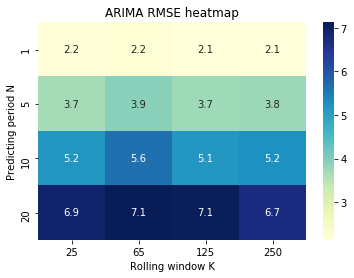

In [28]:
# plot heatmap of RMSE for different parameter pairs
import seaborn as sns
from pylab import savefig
sns.heatmap(perf_df, cmap="YlGnBu",annot = True)
plt.xlabel('Rolling window K')
plt.ylabel('Predicting period N')
plt.title('ARIMA RMSE heatmap')
plt.savefig('ARIMA_result_heatmap.png', dpi=400,bbox_inches='tight')